In [1]:
import ops
from ops.imports_ipython import *
import ops.firesnake
from ops.firesnake import Snake
from ops.qc import *
import seaborn as sns
from glob import glob
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

# Function to generate file paths
def generate_file_paths(well, tile):
    files = []
    
    # All cycles (all channels)
    for cycle in SBS_CYCLES:
        cycle_files = [preprocess_pattern.format(cycle=cycle, well=well, tile=tile)]
        files.append(cycle_files)
    
    return files

# Custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

### Set directory and sbs parameters:

In [2]:
# Set screen directories
sbs_function_home = "/lab/barcheese01/screens"
sbs_function_dataset = "denali"
home = os.path.join(sbs_function_home, sbs_function_dataset)

# Change working directory to home
os.chdir(home)

# Create the directories
os.makedirs('sbs_1/csv', exist_ok=True)
os.makedirs('sbs_1/tif', exist_ok=True)

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `SBS_CYCLES`: The number and order of SBS cycles
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `df_design`: The path to your guide RNA design file
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [3]:
# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] # , 12, 13
CYCLE_FILES = None

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = 'A1' 
TILES = 50
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Define the file pattern
preprocess_pattern = 'input_sbs_tif/10X_c{cycle}-SBS-{cycle}_{well}_Tile-{tile}.sbs.tif'

# Read and format guide data
df_design = pd.read_csv(os.path.join(home, 'sbs_1/pool10_design.csv'), index_col=None)
df_pool = df_design.query('dialout==[0,1]').drop_duplicates('sgRNA')
df_pool['prefix'] = df_pool.apply(lambda x: x.sgRNA[:x.prefix_length], axis=1) # 13
barcodes = df_pool['prefix']

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000]   # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

### Run sbs snakemake pipeline on one well / tile combination

##### load files

In [4]:
input_files = generate_file_paths(WELLS, TILES)
all_files = [item for sublist in input_files for item in sublist]

# Print the files
for f in all_files:
    print(f)
    
# manually change saving directory to sbs_1 directory
description = parse(all_files[0])
description.pop('cycle')
description.pop('tag')
description

input_sbs_tif/10X_c1-SBS-1_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c2-SBS-2_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c3-SBS-3_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c4-SBS-4_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c5-SBS-5_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c6-SBS-6_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c7-SBS-7_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c8-SBS-8_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c9-SBS-9_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c10-SBS-10_A1_Tile-50.sbs.tif
input_sbs_tif/10X_c11-SBS-11_A1_Tile-50.sbs.tif


{'subdir': 'input_sbs_tif',
 'mag': '10X',
 'well': 'A1',
 'tile': '50',
 'ext': 'tif',
 'file': 'input_sbs_tif/10X_c1-SBS-1_A1_Tile-50.sbs.tif'}

In [5]:
input_images = [read(f) for f in all_files]
print(len(input_images))

11


##### align

In [7]:
# This corresponds to the 'align' rule in Snakemake
aligned = Snake._align_SBS(input_images, method='SBS_mean', cycle_files=CYCLE_FILES, upsample_factor = 1, n = 1, keep_extras=False)
print(aligned.shape) # expected dimensions of (CYCLE, CHANNEL, I, J)
save(name(description, tag='aligned', subdir='sbs_1/tif'), aligned, display_ranges=DISPLAY_RANGES, luts=LUTS) # play around with display ranges

(11, 5, 1200, 1200)


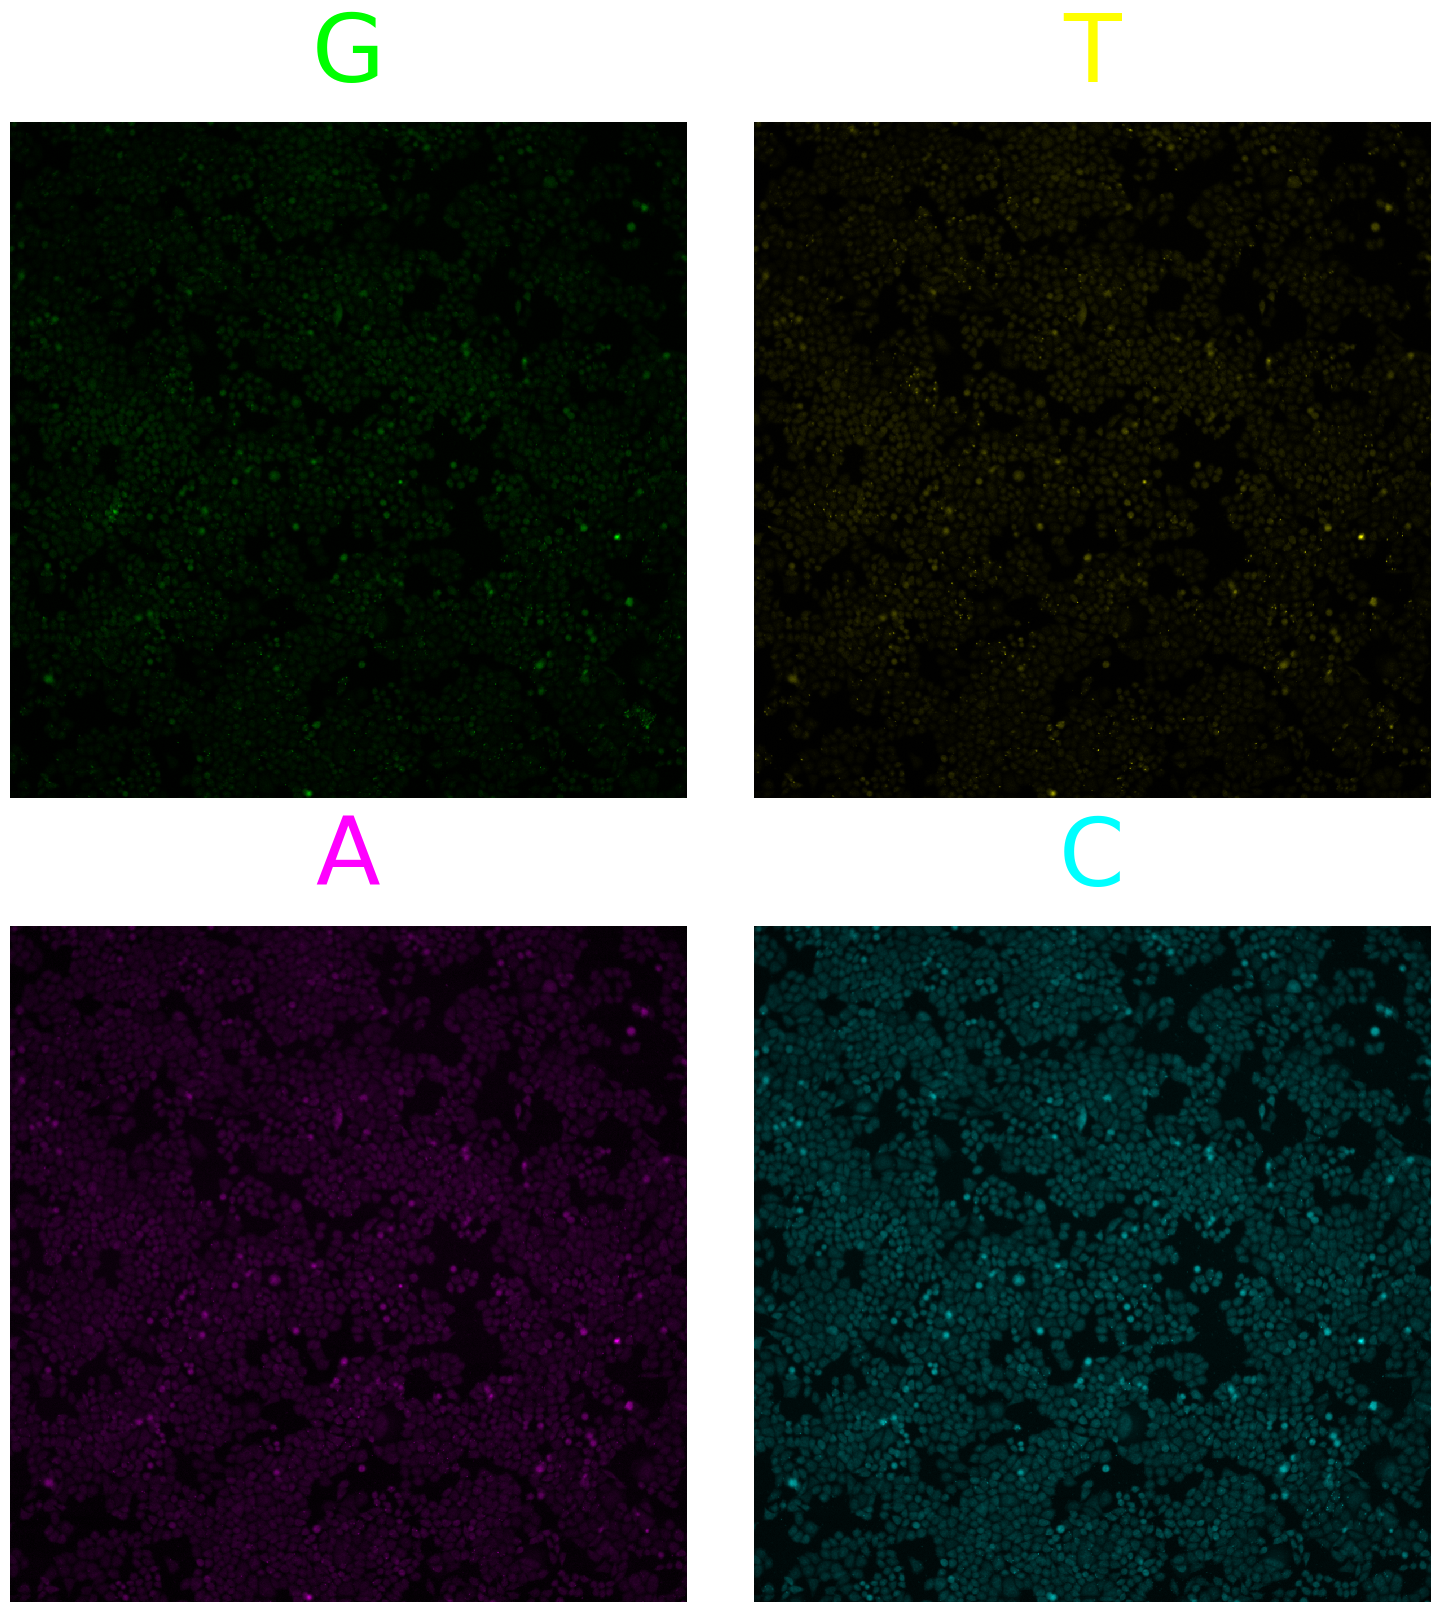

In [8]:
# show aligned for one round
g_aligned_microshow = microplot.Microimage(aligned[0,1,:,:],
                                           cmaps = 'pure_green',
                                           channel_names='G')
t_aligned_microshow = microplot.Microimage(aligned[0,2,:,:],
                                           cmaps = 'pure_yellow',
                                           channel_names='T')
a_aligned_microshow = microplot.Microimage(aligned[0,3,:,:],
                                           cmaps = 'pure_magenta',
                                           channel_names='A')
c_aligned_microshow = microplot.Microimage(aligned[0,4,:,:],
                                           cmaps = 'pure_cyan',
                                           channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], g_aligned_microshow);
panel.add_element([0,1], t_aligned_microshow);
panel.add_element([1,0], a_aligned_microshow);
panel.add_element([1,1], c_aligned_microshow);
panel.add_channel_label()

##### apply Laplacian-of-Gaussian filter (log)

In [9]:
# This corresponds to the 'transform_LoG' rule in Snakemake
loged = Snake._transform_log(aligned, skip_index=0)
print(loged.shape)
save(name(description, tag='log', subdir='sbs_1/tif'), loged, display_ranges=DISPLAY_RANGES, luts=LUTS)

(11, 5, 1200, 1200)


##### detect candidate reads

In [10]:
# This corresponds to the 'compute_std' rule in Snakemake
std = Snake._compute_std(loged, remove_index=0)
print(std.shape)
save(name(description, tag='std', subdir='sbs_1/tif'), std)

(1200, 1200)


In [11]:
# This corresponds to the 'find_peaks' rule in Snakemake
peaks = Snake._find_peaks(std)
print(peaks.shape)
save(name(description, tag='peaks', subdir='sbs_1/tif'), peaks)

(1200, 1200)


In [12]:
# This corresponds to the 'max_filter' rule in Snakemake
maxed = Snake._max_filter(loged, width=3, remove_index=0)
print(maxed.shape)
save(name(description, tag='maxed', subdir='sbs_1/tif'), maxed, display_ranges=DISPLAY_RANGES[1:], luts=LUTS[1:])

(11, 4, 1200, 1200)


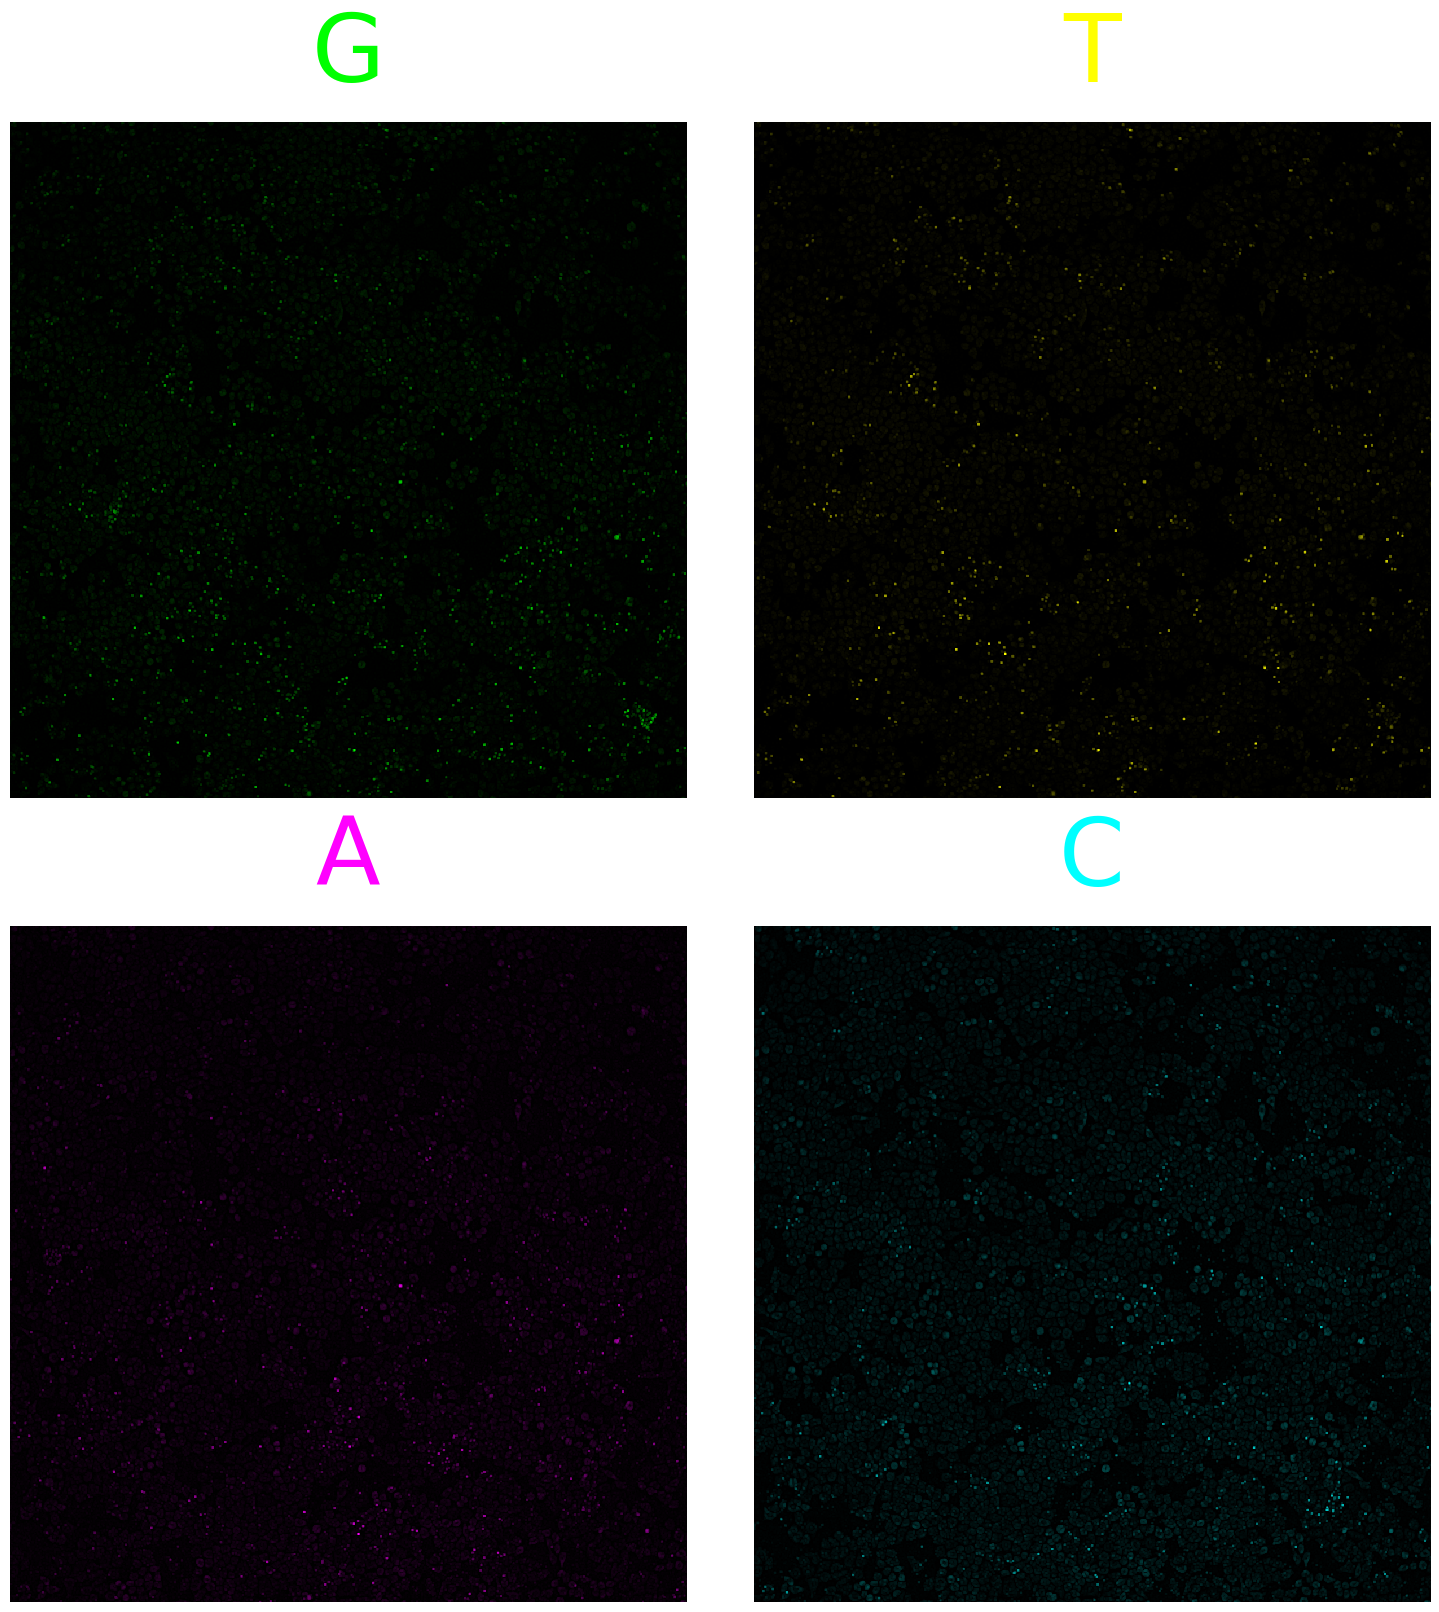

In [13]:
# show max filtered data for one round
g_maxed_microshow = microplot.Microimage(maxed[0,0,:,:],
                                         cmaps = 'pure_green',
                                         channel_names='G')
t_maxed_microshow = microplot.Microimage(maxed[0,1,:,:],
                                         cmaps = 'pure_yellow',
                                         channel_names='T')
a_maxed_microshow = microplot.Microimage(maxed[0,2,:,:],
                                         cmaps = 'pure_magenta',
                                         channel_names='A')
c_maxed_microshow = microplot.Microimage(maxed[0,3,:,:],
                                         cmaps = 'pure_cyan',
                                         channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], g_maxed_microshow);
panel.add_element([0,1], t_maxed_microshow);
panel.add_element([1,0], a_maxed_microshow);
panel.add_element([1,1], c_maxed_microshow);
panel.add_channel_label()

##### apply illumination correction

The following cell contains an important variable for illumination correction and subsequent segmentation. Please review and adjust this variable based on your specific experimental data before proceeding with the analysis.

- `SEGMENTATION_CYCLE`: Determines which cycle is used for segmentation and illumination correction. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.

Ensure this variable accurately reflects the optimal cycle in your experimental data to guarantee effective illumination correction and segmentation.

In [14]:
# Define segmentation cycle
SEGMENTATION_CYCLE = -1

In [15]:
# Read the illumination correction file
icf_file = f'illumination_correction/10X_c{SBS_CYCLES[SEGMENTATION_CYCLE]}-SBS-{SBS_CYCLES[SEGMENTATION_CYCLE]}_{WELLS}.sbs.illumination_correction.tif'
correction = read(os.path.join(home, icf_file))

# This corresponds to the 'illumination_correction' rule in Snakemake
illumination_correction = Snake._apply_illumination_correction(aligned[SEGMENTATION_CYCLE], correction=correction)
print(illumination_correction.shape)
save(name(description, tag='illumination_correction', subdir='sbs_1/tif'), illumination_correction, display_ranges=DISPLAY_RANGES, luts=LUTS)

(5, 1200, 1200)


The following cell contains important variables for preparing the image for Cellpose segmentation. Please review and adjust these variables based on your specific experimental setup before proceeding with the analysis.

- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.

Ensure these variables accurately reflect the channel organization in your experimental data to guarantee effective Cellpose segmentation.

In [16]:
# Define Cellpose segmentation parameters
DAPI_INDEX = 0 
CYTO_CHANNEL = 4  

In [17]:
# Generate a file for testing Cellpose (this is wrapped into segmentation, and is not run in snakemake)
cellpose_rgb = Snake._prepare_cellpose(illumination_correction, DAPI_INDEX, CYTO_CHANNEL)
print(cellpose_rgb.shape)
save(name(description, tag='prepared_cellpose', subdir='sbs_1/tif'), cellpose_rgb)

(3, 1200, 1200)


/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


##### segment nuclei and cells

There are two segmentation methods available:

1. **Cellpose method** (recommended):
   - Uses machine learning-based segmentation
   - Parameters: `NUCLEI_DIAMETER`, `CELL_DIAMETER`, `CYTO_MODEL`

2. **cell_2019 method**: 
   - Uses thresholding and area constraints
   - Parameters: `THRESHOLD_DAPI`, `THRESHOLD_CELL`, `NUCLEUS_AREA`

Choose the appropriate method by setting the `SEGMENT_METHOD` variable to either "cell_2019" or "cellpose".

Please review and adjust the segmentation parameters based on your calibration results and specific experimental setup before proceeding with the analysis.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y mdiberna@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `sbs_1/tif/10X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [18]:
# Define segmentation parameters
SEGMENT_METHOD = "cellpose"  # Options: "cellpose" or "cell_2019"

# Parameters for cellpose method
NUCLEI_DIAMETER = 13.2  # User-specific: Calculated by running Cellpose calibration
CELL_DIAMETER = 19.5    # User-specific: Calculated by running Cellpose calibration
CYTO_MODEL = "cyto3"    # Cellpose model to use

# Parameters for cell_2019 method 
THRESHOLD_DAPI = 1000   # Threshold for segmenting nuclei based on DAPI signal
THRESHOLD_CELL = 2500    # Threshold for segmenting cells on SBS background signal
NUCLEUS_AREA = (20,800)  # Min and max nucleus area

In [19]:
# This corresponds to the 'segment' rule in Snakemake
if SEGMENT_METHOD == "cellpose":
    data = illumination_correction
    print(data.shape)
    nuclei, cells = Snake._segment_cellpose(
        data, 
        dapi_index=DAPI_INDEX, 
        cyto_index=CYTO_CHANNEL, 
        nuclei_diameter=NUCLEI_DIAMETER, 
        cell_diameter=CELL_DIAMETER, 
        cyto_model=CYTO_MODEL
    )
elif SEGMENT_METHOD == "cell_2019":
    data = illumination_correction
    print(data.shape)
    nuclei, cells = Snake._segment_cell_2019(
        data, 
        nuclei_threshold=THRESHOLD_DAPI, 
        nuclei_area_min=NUCLEUS_AREA[0], 
        nuclei_area_max=NUCLEUS_AREA[1], 
        cell_threshold=THRESHOLD_CELL
    )
else:
    raise ValueError(f"Invalid SEGMENT_METHOD: {SEGMENT_METHOD}. Choose 'cellpose' or 'cell_2019'.")

save(name(description, tag='nuclei', subdir='sbs_1/tif'), nuclei, compress=1)
save(name(description, tag='cells', subdir='sbs_1/tif'), cells, compress=1)

(5, 1200, 1200)


/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
found 3658 nuclei before removing edges
found 3608 cells before removing edges
found 3612 nuclei before reconciling
found 3524 cells before reconciling


removing edges
reconciling masks with method how=consensus
Number of nuclei segmented: 3473
Number of cells segmented: 3473


found 3473 nuclei/cells after reconciling


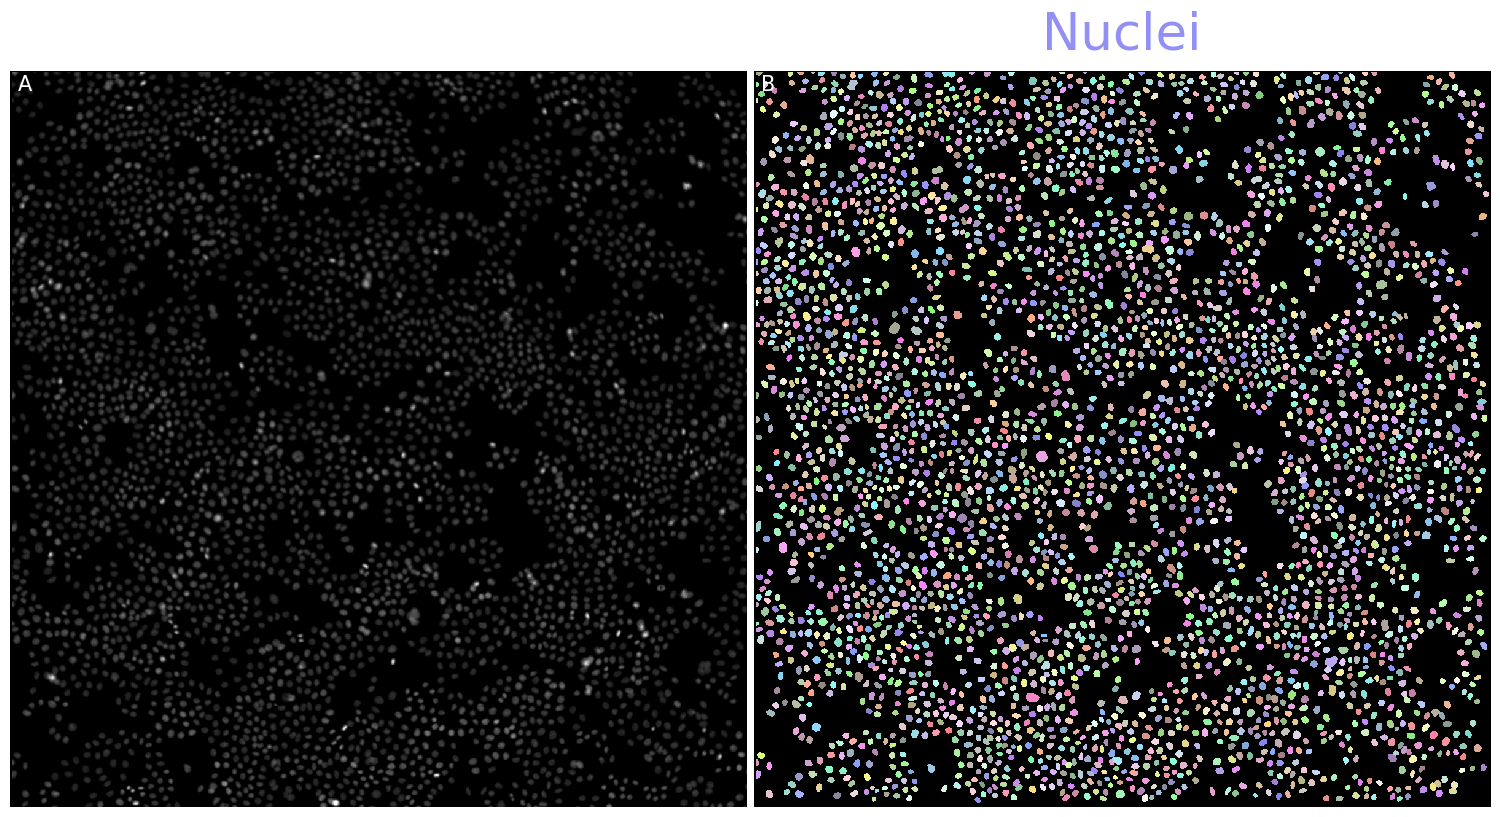

In [20]:
# Create microshow plots for each channel with specified colormaps and display ranges
dapi_microshow = microplot.Microimage(illumination_correction[0, :, :],
                                      rescale_type='limits', 
                                      limits=DISPLAY_RANGES[0],
                                      label_text='A', 
                                      channel_names='Dapi')

nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei,
                                        label_text='B',
                                        cmaps = nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], dapi_microshow);
panel.add_element([0,1], nuclei_microshow);
panel.add_channel_label()

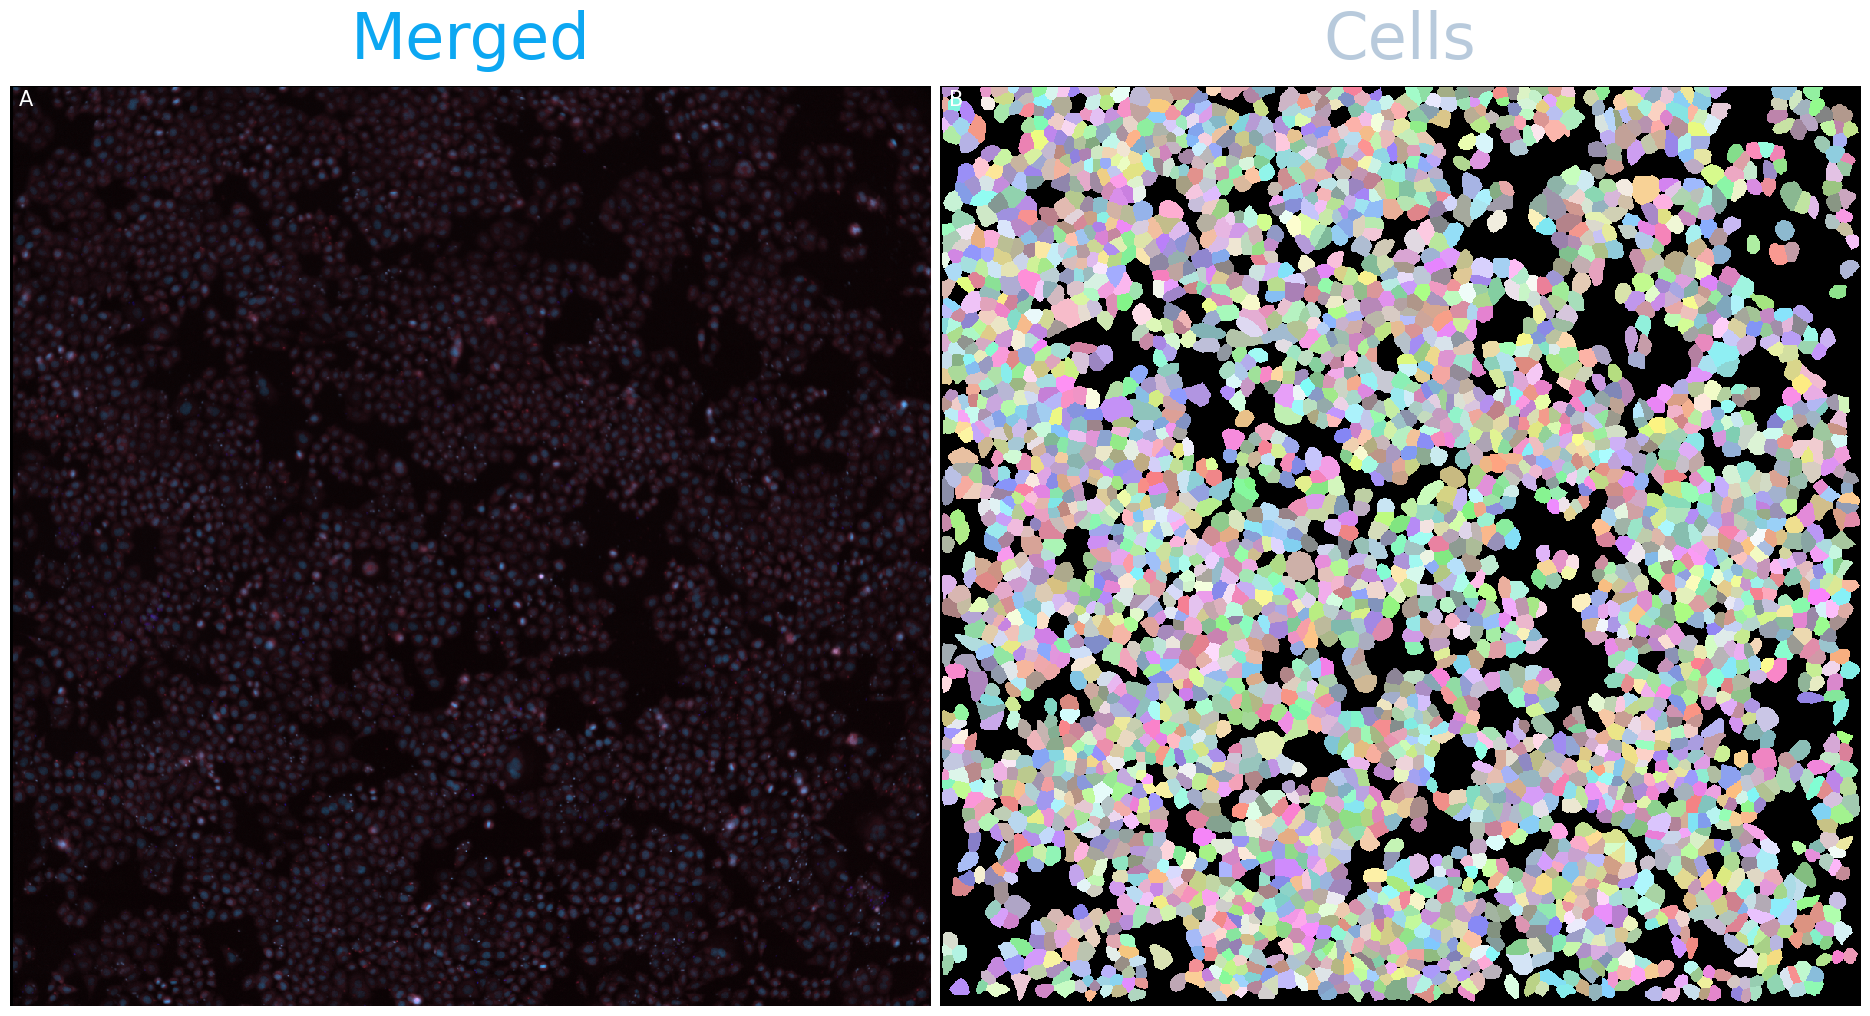

In [21]:
# Create microshow plots for each channel with specified colormaps and display ranges
all_microshow = microplot.Microimage(illumination_correction,
                                     label_text='A',
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES,
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps = cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0,0], all_microshow);
panel.add_element([0,1], cells_microshow);
panel.add_channel_label()

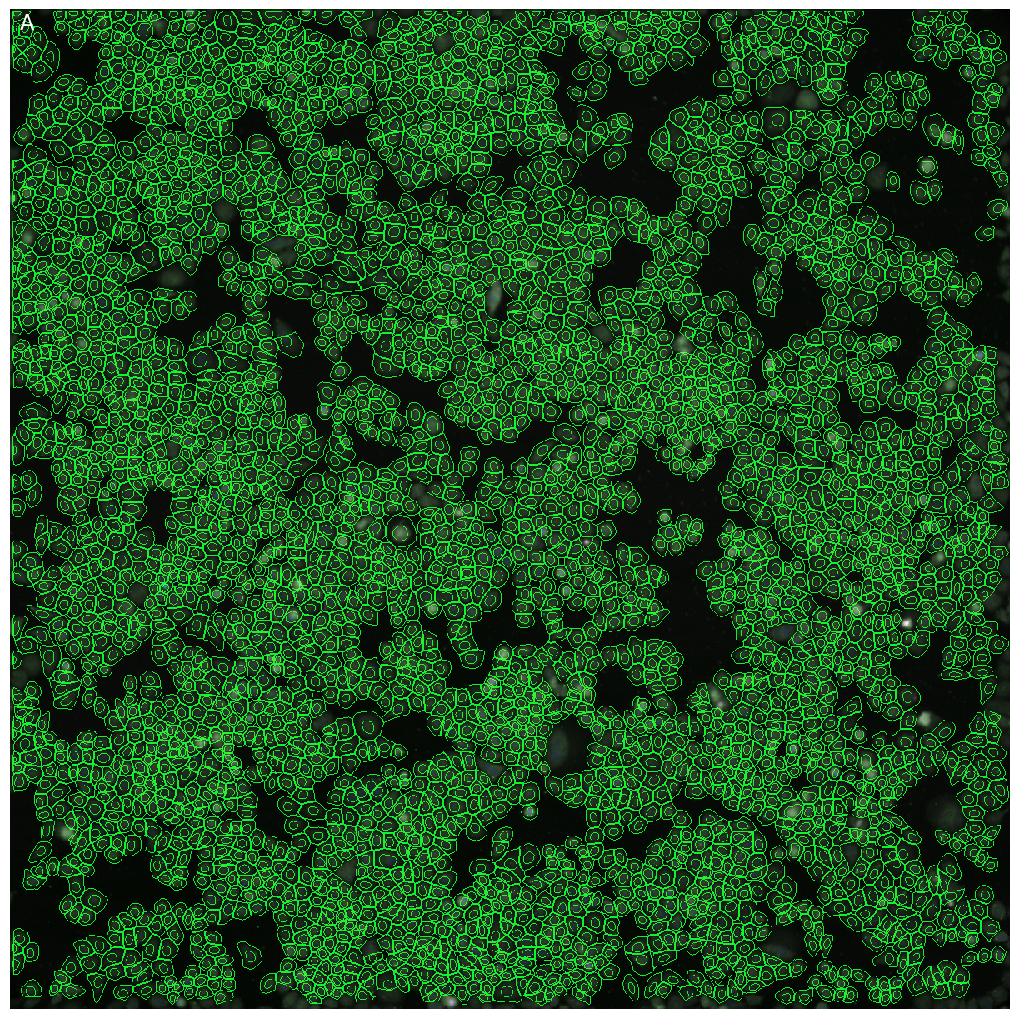

In [22]:
# Create microshow from annotated data
annotated_data=Snake._annotate_segment_on_sequencing_data(aligned, nuclei, cells)
save(name(description, tag='segmentation', subdir='sbs_1/tif'), annotated_data)
annotated_microshow = microplot.Microimage(annotated_data[0, :, :, :],
                                           label_text='A',
                                           channel_names='Merged')

panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0,0], annotated_microshow);

##### extract base intensity, call reads, assign to cells

The following cell contains important parameters for extracting bases from the sequencing data. Please review and adjust these variables based on your specific experimental setup before proceeding with the analysis.

- `THRESHOLD_READS`: The intensity threshold for detecting sequencing reads. Adjust this value based on the signal-to-noise ratio in your data.
- `BASES`: The order of bases used in your sequencing. This should match the order of channels in your sequencing data.

Ensure these variables accurately reflect your experimental conditions to guarantee correct base calling and downstream analysis.

In [23]:
# Define parameters for extracting bases
THRESHOLD_READS = 315
BASES = 'GTAC' 

In [24]:
# This corresponds to the 'exract_bases' rule in Snakemake
df_bases = Snake._extract_bases(maxed, peaks, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
df_bases.to_csv(name(description, tag='bases', ext='csv', subdir='sbs_1/csv'), index=None)
df_bases

read  cycle channel  intensity  cell     i     j  tile well
44         1      1       A        394     0     5   586    50   A1
45         1      1       C        323     0     5   586    50   A1
46         1      1       G        107     0     5   586    50   A1
47         1      1       T        111     0     5   586    50   A1
48         1      2       A       2970     0     5   586    50   A1
...      ...    ...     ...        ...   ...   ...   ...   ...  ...
152103  3456     10       T         38  3471  1182  1050    50   A1
152104  3456     11       A        329  3471  1182  1050    50   A1
152105  3456     11       C        982  3471  1182  1050    50   A1
152106  3456     11       G        126  3471  1182  1050    50   A1
152107  3456     11       T         54  3471  1182  1050    50   A1

[153648 rows x 9 columns]

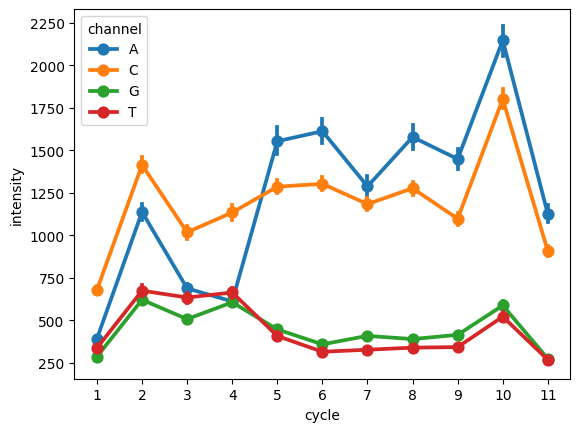

In [25]:
# Show intensity across cycles
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

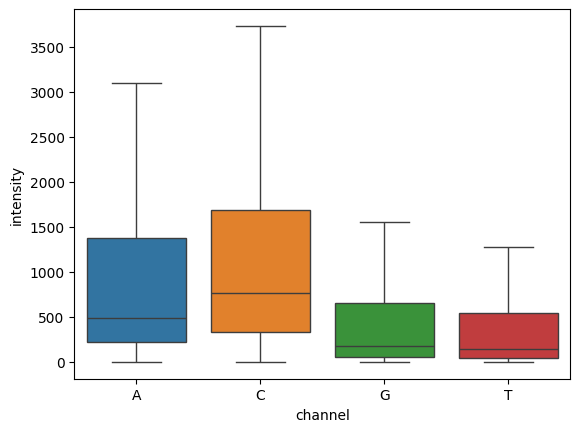

In [26]:
# Show intensity for each base
ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False)
plt.show()

In [27]:
# This corresponds to the 'call_reads' rule in Snakemake
df_reads = Snake._call_reads(df_bases, peaks=peaks)
df_reads.to_csv(name(description, tag='reads', ext='csv', subdir='sbs_1/csv'), index=None)
df_reads

read  cell     i     j  tile well      barcode       Q_0  Q_1  \
44         1     0     5   586    50   A1  AAGATGCCCAA  0.738140  1.0   
572       13     0     9  1178    50   A1  GGCAAAGCGGG  0.738140  1.0   
1100      25     0    16   173    50   A1  TTCAACAATCT  1.000000  1.0   
1364      31     0    18   436    50   A1  AGCCGGCGAAG  0.000000  1.0   
1760      40     0    21   189    50   A1  TTAAAGAAAGG  1.000000  1.0   
...      ...   ...   ...   ...   ...  ...          ...       ...  ...   
151888  3452  3467  1181   255    50   A1  GAACACATAGC  0.415037  1.0   
152724  3471  3467  1187   248    50   A1  GTTCTAAGAGC  0.634788  1.0   
153120  3480  3467  1191   252    50   A1  ATTGTGTTGCA  1.000000  1.0   
152768  3472  3469  1187   568    50   A1  TATCTCCACTA  0.738140  1.0   
152064  3456  3471  1182  1050    50   A1  TCAACCACGCC  1.000000  1.0   

            Q_2       Q_3      Q_4       Q_5      Q_6  Q_7      Q_8       Q_9  \
44      1.00000  0.773706  1.00000  0.870850  1.00000  1.0  1.00000  1.000000   
572     1.00000  1.000000  1.00000  1.000000  1.00000  1.0  1.00000  1.000000   
1100    0.60206  0.000000  1.00000  0.415037  1.00000  1.0  1.00000  0.276692   
1364    1.00000  1.000000  0.73814  0.738140  0.73814  1.0  1.00000  1.000000   
1760    1.00000  1.000000  1.00000  1.000000  1.00000  1.0  1.00000  1.000000   
...         ...       ...      ...       ...      ...  ...      ...       ...   
151888  1.00000  1.000000  1.00000  1.000000  1.00000  1.0  1.00000  1.000000   
152724  1.00000  1.000000  1.00000  1.000000  1.00000  1.0  1.00000  0.919047   
153120  1.00000  1.000000  1.00000  1.000000  1.00000  1.0  1.00000  1.000000   
152768  1.00000  0.634788  1.00000  0.738140  0.73814  1.0  0.73814  1.000000   
152064  1.00000  0.415037  1.00000  1.000000  1.00000  1.0  1.00000  1.000000   

            Q_10     Q_min        peak  
44      0.943358  0.738140  623.434982  
572     0.738140  0.738140  375.344595  
1100    1.000000  0.000000  713.438907  
1364    0.738140  0.000000  341.744631  
1760    0.738140  0.738140  386.844782  
...          ...       ...         ...  
151888  0.738140  0.415037  417.691396  
152724  1.000000  0.634788  722.334264  
153120  1.000000  1.000000  532.106728  
152768  0.000000  0.000000  331.462610  
152064  1.000000  0.415037  434.856014  

[3492 rows x 20 columns]

peak_threshold  mapping_rate  mapped_spots
0               0.0      0.743411        2454.0
1              10.0      0.743411        2454.0
2              20.0      0.743411        2454.0
3              30.0      0.743411        2454.0
4              40.0      0.743411        2454.0
..              ...           ...           ...
190          1900.0      0.866667          39.0
191          1910.0      0.857143          36.0
192          1920.0      0.846154          33.0
193          1930.0      0.842105          32.0
194          1940.0      0.857143          30.0

[195 rows x 3 columns]

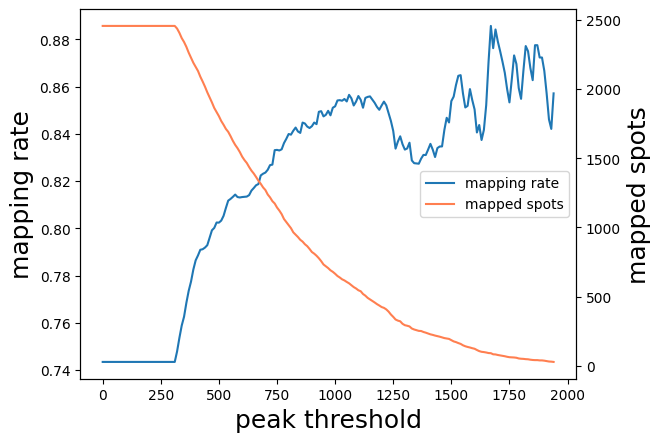

In [28]:
# Plot the mapping rate vs. peak threshold to help determine optimal peak cutoff
plot_mapping_vs_threshold(df_reads, barcodes, "peak")

Q_min_threshold  mapping_rate  mapped_spots
0              0.000      0.842330        2169.0
1              0.001      0.842330        2169.0
2              0.002      0.842330        2169.0
3              0.003      0.842330        2169.0
4              0.004      0.842330        2169.0
..               ...           ...           ...
995            0.995      0.918483         969.0
996            0.996      0.918483         969.0
997            0.997      0.918483         969.0
998            0.998      0.918483         969.0
999            0.999      0.918483         969.0

[1000 rows x 3 columns]

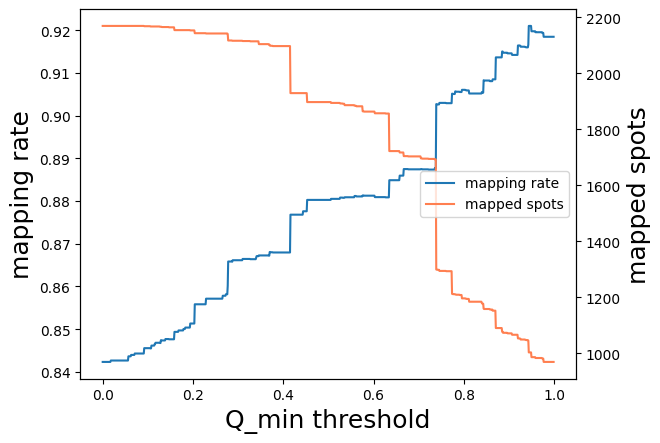

In [29]:
# Plot the mapping rate vs. Q_min to help determine optimal sequence quality cutoff
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")

In [30]:
# Make alternate annotation tif images
annotated_bases=Snake._annotate_bases_on_SBS_log(loged, df_reads)
save(name(description, tag='annotated_bases', subdir='sbs_1/tif'), annotated_bases)
annotated_reads=Snake._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="reads")
save(name(description, tag='annotated_reads', subdir='sbs_1/tif'), annotated_reads)
annotated_peaks=Snake._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="peaks")
save(name(description, tag='annotated_peaks', subdir='sbs_1/tif'), annotated_peaks)

The following cell contains an important parameter for filtering sequencing reads based on their quality. Please review and adjust this variable based on your specific experimental needs before proceeding with the analysis.

- `Q_MIN`: The minimum Levenshtein distance allowed between a read and its closest barcode match. A value of 0 means only perfect matches are accepted, while higher values allow for more mismatches.

Ensure this variable is set appropriately for your experiment. A lower value increases stringency but may reduce the number of accepted reads, while a higher value allows for more reads but may increase false positives.

In [31]:
# Define parameters for read mapping
Q_MIN = 0 

In [32]:
# This corresponds to the 'call_cells' rule in Snakemake
df_cells = Snake._call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
df_cells.to_csv(name(description, tag='cells', ext='csv', subdir='sbs_1/csv'), index=None)
df_cells

cell  tile well       Q_0       Q_1      Q_2       Q_3       Q_4  \
0        3    50   A1  1.000000  1.000000  1.00000  0.415037  1.000000   
1        5    50   A1  0.738140  1.000000  1.00000  1.000000  1.000000   
2        9    50   A1  1.000000  0.919047  1.00000  0.666667  1.000000   
3       10    50   A1  0.000000  1.000000  1.00000  1.000000  1.000000   
4       11    50   A1  1.000000  1.000000  1.00000  1.000000  1.000000   
...    ...   ...  ...       ...       ...      ...       ...       ...   
2051  3463    50   A1  1.000000  1.000000  0.87085  0.943358  0.943358   
2052  3466    50   A1  1.000000  1.000000  1.00000  0.738140  1.000000   
2053  3467    50   A1  0.415037  1.000000  1.00000  1.000000  1.000000   
2054  3469    50   A1  0.738140  1.000000  1.00000  0.634788  1.000000   
2055  3471    50   A1  1.000000  1.000000  1.00000  0.415037  1.000000   

          Q_5       Q_6  ...  cell_barcode_count_0  cell_barcode_1  \
0     1.00000  1.000000  ...                     2             NaN   
1     1.00000  1.000000  ...                     1             NaN   
2     1.00000  1.000000  ...                     1             NaN   
3     1.00000  1.000000  ...                     1             NaN   
4     1.00000  1.000000  ...                     1             NaN   
...       ...       ...  ...                   ...             ...   
2051  1.00000  0.634788  ...                     1     GAAATAACAGA   
2052  1.00000  1.000000  ...                     1             NaN   
2053  1.00000  1.000000  ...                     1     GAACACATAGC   
2054  0.73814  0.738140  ...                     1             NaN   
2055  1.00000  1.000000  ...                     1             NaN   

      cell_barcode_count_1  barcode_count               sgRNA_0  \
0                      0.0              2  CACAGCACTAAATACAACTC   
1                      0.0              1  AGGACTTGGATCTGAGCTAA   
2                      0.0              1  TGTCGTTCTCTATCACTACG   
3                      0.0              1                   NaN   
4                      0.0              1  GATGGCAATCACATCCCCGG   
...                    ...            ...                   ...   
2051                   1.0              2  GAAATACCACAGGCTTATCG   
2052                   0.0              1  TCAATTACGATTATCGGTGG   
2053                   1.0              3  ATTGTGTTGCAGGATTGGGA   
2054                   0.0              1                   NaN   
2055                   0.0              1  TCAACCACGCCAACGCTGGG   

      gene_symbol_0  gene_id_0               sgRNA_1  gene_symbol_1 gene_id_1  
0              NAE1       8883                   NaN            NaN       NaN  
1              POMP      51371                   NaN            NaN       NaN  
2              OST4  100128731                   NaN            NaN       NaN  
3               NaN        NaN                   NaN            NaN       NaN  
4              UFD1       7353                   NaN            NaN       NaN  
...             ...        ...                   ...            ...       ...  
2051           PAN2       9924                   NaN            NaN       NaN  
2052          AIFM1       9131                   NaN            NaN       NaN  
2053         PTP4A2       8073  GAACACATAGCCTAGCTCAG           UROD      7389  
2054            NaN        NaN                   NaN            NaN       NaN  
2055         SERBP1      26135                   NaN            NaN       NaN  

[2056 rows x 28 columns]

In [33]:
# This corresponds to the 'sbs_cell_info' rule in Snakemake
df_sbs_info = Snake._extract_phenotype_minimal(data_phenotype=nuclei, nuclei = nuclei, wildcards=WILDCARDS)
df_sbs_info.to_csv(name(description, tag='sbs_info', ext='csv', subdir='sbs_1/csv'), index=None)
df_sbs_info

area            i            j  cell                    bounds  tile  \
0       48     5.145833     7.916667     1             (3, 4, 9, 14)    50   
1       55     6.127273    58.472727     2           (3, 55, 11, 63)    50   
2       52     4.826923    75.884615     3            (3, 70, 8, 82)    50   
3       15     3.800000    95.400000     4            (3, 93, 6, 99)    50   
4       64     5.875000   108.812500     5         (3, 104, 10, 115)    50   
...    ...          ...          ...   ...                       ...   ...   
3468    74  1185.770270   568.054054  3469    (1182, 563, 1191, 574)    50   
3469    90  1185.733333   952.811111  3470    (1182, 947, 1191, 960)    50   
3470    68  1186.161765  1050.691176  3471  (1182, 1047, 1192, 1056)    50   
3471    51  1186.803922   194.627451  3472    (1183, 192, 1192, 199)    50   
3472    67  1188.253731   363.716418  3473    (1184, 359, 1193, 369)    50   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
3468   A1  
3469   A1  
3470   A1  
3471   A1  
3472   A1  

[3473 rows x 7 columns]

In [35]:
# Generate a summary of the fraction of cells mapping to one barcode
plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='one', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)

well  tile  fraction of cells mapping to 1 barcode
1   A1    50                                0.420674

In [36]:
# Generate a summary of the fraction of cells mapping to any barcode
plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='any', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)

well  tile  fraction of cells mapping to >=1 barcode
1   A1    50                                  0.481716

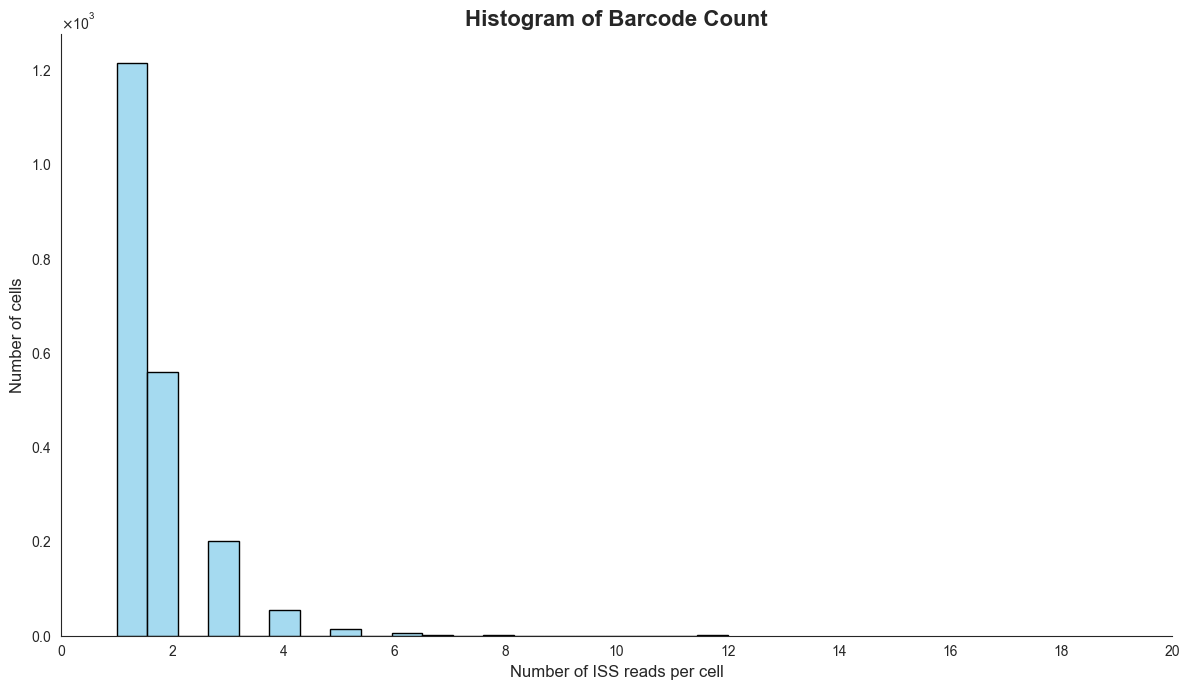

Series([], Name: barcode_count, dtype: int64)

In [37]:
# Plot a histogram of the number of reads per cell
plot_reads_per_cell_histogram(df_cells, x_cutoff = 20)

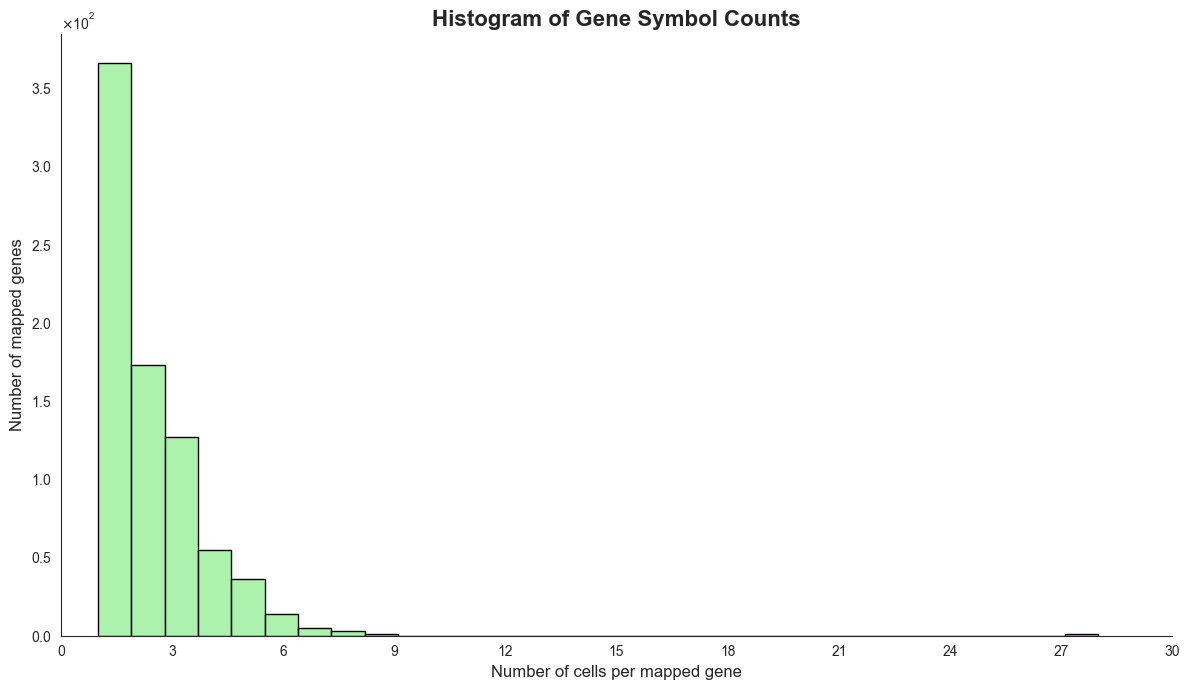

Series([], Name: count, dtype: int64)

In [39]:
# Plot a histogram of the number of counts of each unique gene symbols
plot_gene_symbol_histogram(df_cells, x_cutoff = 30)